# Определение перспективного тарифа для телеком компании

## Описание проекта

Федеральный оператор сотовой связи компания "Мегалайн" предлагает клиентам два тарифа: «Смарт» и «Ультра». 

Задача аналитика в данном проекте заключается в том, чтобы выяснить, какой тариф приносит больше денег.

Данные предоставлены заказчиком - коммерческим департаментом, цель которого заключается в корректировке рекламного бюджета. 

Аналитику необходимо провести предварительный анализ на выборке из 500 клиентов. 

Датасет содержит информацию об этих 500 пользователях: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. 

На основе анализа поведения пользователей необходимо определить, какой тариф лучше. 

## Изучение общей информации и подготовка данных из файлов

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import math as mt
from math import factorial

In [2]:
#выгружаю все таблицы

calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

In [3]:
#смотрю таблицу звонков
calls.info()
calls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


In [4]:
#перевожу столбец call_date в формат datetime и проверяю результат
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [5]:
#получаю столбец месяц для дальнейшей группировки
calls['month'] = calls['call_date'].dt.month
#по условию каждый звонок округляется до минуты, поэтому округляю длительность всех звонков в большую сторону
calls['duration'] = np.ceil(calls['duration'])

calls.head(20)

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.0,1000,7
1,1000_1,2018-08-17,0.0,1000,8
2,1000_2,2018-06-11,3.0,1000,6
3,1000_3,2018-09-21,14.0,1000,9
4,1000_4,2018-12-15,6.0,1000,12
5,1000_5,2018-11-02,0.0,1000,11
6,1000_6,2018-10-18,0.0,1000,10
7,1000_7,2018-08-22,19.0,1000,8
8,1000_8,2018-09-15,19.0,1000,9
9,1000_9,2018-08-15,0.0,1000,8


In [6]:
#создаю сгруппированную таблицу со звонками: с суммой минут и количеством звонков по каждому пользователю за каждый месяц
calls_grpd = calls.groupby(['user_id', 'month']).agg({'duration': ['sum', 'count']}).reset_index()
#переименовываю столбцы 
calls_grpd.columns = ['user_id', 'month', 'duration_sum', 'duration_count']
calls_grpd

,user_id,month,duration_sum,duration_count
0,1000,5,159.0,22
1,1000,6,172.0,43
2,1000,7,340.0,47
3,1000,8,408.0,52
4,1000,9,466.0,58
...,...,...,...,...
3169,1498,10,247.0,41
3170,1499,9,70.0,9
3171,1499,10,449.0,68
3172,1499,11,612.0,74


In [7]:
internet.info()
internet

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499


In [8]:
#аналогично таблице со звонками делаю все по интернет-трафику: меняю тип столбца даты
internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y-%m-%d')
#выделяю столбец месяц
internet['month'] = internet['session_date'].dt.month
#группирую новую таблицу по каждому юзеру за месяц с количеством трафика и количеством сессий
internet_grpd = internet.groupby(['user_id', 'month']).agg({'mb_used': ['sum', 'count']}).reset_index()
internet_grpd.columns = ['user_id', 'month', 'mb_used_sum', 'internet_used_count']
#в сгруппированной таблице округляю мегабайты до гигабайт за месяц в большую сторону, в соотвутствии с условием 
internet_grpd['gb_used_sum'] = np.ceil(internet_grpd['mb_used_sum'] / 1024)
internet_grpd.drop('mb_used_sum', axis=1, inplace=True)
internet_grpd


,user_id,month,internet_used_count,gb_used_sum
0,1000,5,5,3.0
1,1000,6,49,23.0
2,1000,7,29,14.0
3,1000,8,29,14.0
4,1000,9,27,15.0
...,...,...,...,...
3198,1498,10,59,21.0
3199,1499,9,5,2.0
3200,1499,10,58,18.0
3201,1499,11,49,18.0


In [9]:
messages.info()
messages

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


In [10]:
#в таблице сообщения меняю тип столбца дата и выделяю месяц отправки сообщения
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y-%m-%d')
messages['month'] = messages['message_date'].dt.month
#создаю сгруппированную таблицу по каждому юзеру по количеству сообщений в месяц 
messages_grpd = messages.groupby(['user_id', 'month']).agg({'message_date': ['count']}).reset_index()
messages_grpd.columns = ['user_id', 'month', 'messages_count']
messages_grpd


,user_id,month,messages_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


In [11]:
tariffs.info()
tariffs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [12]:
users.info()
users

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


In [13]:
#в столбце churn_date очень много пропущенных, предполагаю, что это означает, что пользователи все еще пользуются своим тарифом
#предварительно заменила на 2099 год как маркер 
users['churn_date'] = users['churn_date'].fillna('2099-01-01')
users['churn_date'] = pd.to_datetime(users['churn_date'], format = '%Y-%m-%d')
#проверяю таблицу на дубликаты
users.duplicated().sum()

0

In [14]:
#объединяю необходимые мне для анализа данные в одну таблицу
df = calls_grpd.merge(messages_grpd, how = 'outer', on = ['user_id', 'month']).merge(internet_grpd, how = 'outer', on = ['user_id', 'month']).merge(users[['user_id', 'tariff', 'city']], how = 'left', on = ['user_id'])
df.isna().sum()
df = df.fillna(0)

df.isna().sum()
df.info()
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 9 columns):
user_id                3214 non-null int64
month                  3214 non-null int64
duration_sum           3214 non-null float64
duration_count         3214 non-null float64
messages_count         3214 non-null float64
internet_used_count    3214 non-null float64
gb_used_sum            3214 non-null float64
tariff                 3214 non-null object
city                   3214 non-null object
dtypes: float64(5), int64(2), object(2)
memory usage: 251.1+ KB


,user_id,month,duration_sum,duration_count,messages_count,internet_used_count,gb_used_sum,tariff,city
0,1000,5,159.0,22.0,22.0,5.0,3.0,ultra,Краснодар
1,1000,6,172.0,43.0,60.0,49.0,23.0,ultra,Краснодар
2,1000,7,340.0,47.0,75.0,29.0,14.0,ultra,Краснодар
3,1000,8,408.0,52.0,81.0,29.0,14.0,ultra,Краснодар
4,1000,9,466.0,58.0,57.0,27.0,15.0,ultra,Краснодар
...,...,...,...,...,...,...,...,...,...
3209,1489,9,0.0,0.0,32.0,63.0,17.0,smart,Санкт-Петербург
3210,1489,10,0.0,0.0,21.0,63.0,20.0,smart,Санкт-Петербург
3211,1489,11,0.0,0.0,20.0,55.0,18.0,smart,Санкт-Петербург
3212,1489,12,0.0,0.0,35.0,51.0,17.0,smart,Санкт-Петербург


In [15]:
#в таблице тарифы изменила столбец количества мегабайт в месяц на количество гигабайт, а также название столбцов
tariffs
tariffs['mb_per_month_included'] = tariffs['mb_per_month_included'] / 1024
tariffs.columns
tariffs.columns = ['messages_included', 'gb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff_name']
tariffs


,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15.0,500,550,200,3,3,smart
1,1000,30.0,3000,1950,150,1,1,ultra


In [16]:
#соединила таблицу тарифы с общим датафреймом по пользователям
df_tariffs = df.merge(tariffs, left_on = 'tariff', right_on = 'tariff_name', how = 'outer')
df_tariffs.drop('tariff_name', axis=1, inplace=True)
df_tariffs

,user_id,month,duration_sum,duration_count,messages_count,internet_used_count,gb_used_sum,tariff,city,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,159.0,22.0,22.0,5.0,3.0,ultra,Краснодар,1000,30.0,3000,1950,150,1,1
1,1000,6,172.0,43.0,60.0,49.0,23.0,ultra,Краснодар,1000,30.0,3000,1950,150,1,1
2,1000,7,340.0,47.0,75.0,29.0,14.0,ultra,Краснодар,1000,30.0,3000,1950,150,1,1
3,1000,8,408.0,52.0,81.0,29.0,14.0,ultra,Краснодар,1000,30.0,3000,1950,150,1,1
4,1000,9,466.0,58.0,57.0,27.0,15.0,ultra,Краснодар,1000,30.0,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,8,0.0,0.0,17.0,34.0,11.0,smart,Санкт-Петербург,50,15.0,500,550,200,3,3
3210,1489,9,0.0,0.0,32.0,63.0,17.0,smart,Санкт-Петербург,50,15.0,500,550,200,3,3
3211,1489,10,0.0,0.0,21.0,63.0,20.0,smart,Санкт-Петербург,50,15.0,500,550,200,3,3
3212,1489,11,0.0,0.0,20.0,55.0,18.0,smart,Санкт-Петербург,50,15.0,500,550,200,3,3


In [17]:
#функция, возвращающая дополнитеольную плату сверх лимитов по тарифам
def check_tariff(row):
    extra_call_sum = 0
    extra_sms_sum = 0
    extra_internet_sum = 0
    if row['duration_sum'] > row['minutes_included']:        
        extra_call_sum = (row['duration_sum'] - row['minutes_included']) * row['rub_per_minute']        
    if row['messages_count'] > row['messages_included']:
        extra_sms_sum = (row['messages_count'] - row['messages_included']) * row['rub_per_message']        
    if row['gb_used_sum'] > row['gb_per_month_included']:
        extra_internet_sum = np.ceil(row['gb_used_sum'] - row['gb_per_month_included']) * row['rub_per_gb']        
    return (extra_call_sum + extra_sms_sum + extra_internet_sum)
   
#применяю функцию и смотрю результат ее работы на примере запроса по превышению лимитов на тарифе смарт   
df_tariffs['over'] = df_tariffs.apply(check_tariff, axis = 1)
df_tariffs.query('gb_used_sum > 15 and tariff == "smart" and duration_sum > 500 and messages_count > 50').head()


,user_id,month,duration_sum,duration_count,messages_count,internet_used_count,gb_used_sum,tariff,city,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,over
1073,1015,7,556.0,79.0,90.0,63.0,20.0,smart,Челябинск,50,15.0,500,550,200,3,3,1288.0
1076,1015,10,577.0,67.0,68.0,55.0,17.0,smart,Челябинск,50,15.0,500,550,200,3,3,685.0
1106,1026,12,531.0,68.0,57.0,54.0,17.0,smart,Мурманск,50,15.0,500,550,200,3,3,514.0
1117,1029,10,609.0,92.0,62.0,68.0,22.0,smart,Екатеринбург,50,15.0,500,550,200,3,3,1763.0
1183,1042,12,728.0,121.0,75.0,112.0,37.0,smart,Хабаровск,50,15.0,500,550,200,3,3,5159.0


In [18]:
#добавила столбец с итоговой суммой на каждого пользователя за каждый месяц
df_tariffs['user_sum'] = df_tariffs['rub_monthly_fee'] + df_tariffs['over']
df_tariffs


,user_id,month,duration_sum,duration_count,messages_count,internet_used_count,gb_used_sum,tariff,city,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,over,user_sum
0,1000,5,159.0,22.0,22.0,5.0,3.0,ultra,Краснодар,1000,30.0,3000,1950,150,1,1,0.0,1950.0
1,1000,6,172.0,43.0,60.0,49.0,23.0,ultra,Краснодар,1000,30.0,3000,1950,150,1,1,0.0,1950.0
2,1000,7,340.0,47.0,75.0,29.0,14.0,ultra,Краснодар,1000,30.0,3000,1950,150,1,1,0.0,1950.0
3,1000,8,408.0,52.0,81.0,29.0,14.0,ultra,Краснодар,1000,30.0,3000,1950,150,1,1,0.0,1950.0
4,1000,9,466.0,58.0,57.0,27.0,15.0,ultra,Краснодар,1000,30.0,3000,1950,150,1,1,0.0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,8,0.0,0.0,17.0,34.0,11.0,smart,Санкт-Петербург,50,15.0,500,550,200,3,3,0.0,550.0
3210,1489,9,0.0,0.0,32.0,63.0,17.0,smart,Санкт-Петербург,50,15.0,500,550,200,3,3,400.0,950.0
3211,1489,10,0.0,0.0,21.0,63.0,20.0,smart,Санкт-Петербург,50,15.0,500,550,200,3,3,1000.0,1550.0
3212,1489,11,0.0,0.0,20.0,55.0,18.0,smart,Санкт-Петербург,50,15.0,500,550,200,3,3,600.0,1150.0


Изучила данные из файлов, исправила типы данных, заполнила пропуски. <br>
Объединила таблицы для дальнейшего анализа.<br>
Добавила столбцы со сверхтарифными расходами на каждого пользователя в каждом месяце и суммарное количество затрат каждого пользователя

## Анализ данных

In [19]:
#вывожу таблицу со средним, стандартным отклонением и дисперсией для двух тарифов 
df_stat = df_tariffs.pivot_table(index = 'tariff', values = ['duration_sum', 'messages_count', 'gb_used_sum'], aggfunc = ['mean', 'std', 'var'])
df_stat.columns = ['duration_mean', 'gb_used_mean', 'messages_mean', 'duration_std', 'gb_used_std', 'messages_std', 'duration_var', 'gb_used_var', 'messages_var']
df_stat

,duration_mean,gb_used_mean,messages_mean,duration_std,gb_used_std,messages_std,duration_var,gb_used_var,messages_var
tariff,,,,,,,,,
smart,417.934948,16.328847,33.384029,190.313730,5.747061,28.227876,36219.315784,33.028705,796.812958
ultra,526.623350,19.494416,49.363452,317.606098,9.853511,47.804457,100873.633397,97.091686,2285.266143


In [20]:
#Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? 
df_tariffs_grpd = df_tariffs.pivot_table(index = ['tariff', 'month', 'user_id'], values = ['duration_sum', 'messages_count', 'gb_used_sum'], aggfunc = 'sum')
df_tariffs_grpd

duration_sum  gb_used_sum  messages_count
tariff month user_id                                           
smart  1     1005             95.0          3.0             7.0
             1032            380.0         24.0            38.0
             1045              9.0          3.0             5.0
             1055            551.0         17.0            30.0
             1071            194.0         16.0            16.0
...                            ...          ...             ...
ultra  12    1476            588.0         14.0            11.0
             1485            584.0         23.0           155.0
             1491            674.0         22.0            51.0
             1493            571.0         42.0            78.0
             1495           1031.0         23.0            84.0

[3214 rows x 3 columns]

In [21]:
#для построения гистограм делаю отдельные таблицы по тарифам 
df_ultra = df_tariffs_grpd.query('tariff == "ultra"')
df_smart = df_tariffs_grpd.query('tariff == "smart"')
df_smart
df_ultra

duration_sum  gb_used_sum  messages_count
tariff month user_id                                           
ultra  1     1120             55.0          1.0             0.0
             1126            272.0         16.0             4.0
             1168            277.0          8.0            14.0
             1254            466.0         20.0             0.0
             1375            852.0         15.0            75.0
...                            ...          ...             ...
       12    1476            588.0         14.0            11.0
             1485            584.0         23.0           155.0
             1491            674.0         22.0            51.0
             1493            571.0         42.0            78.0
             1495           1031.0         23.0            84.0

[985 rows x 3 columns]

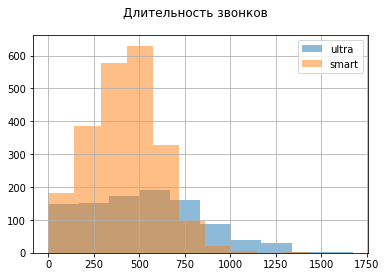

In [22]:
#строю гистограмму распределения длительности звонков в тарифах
df_ultra['duration_sum'].hist(alpha = 0.5)
df_smart['duration_sum'].hist(alpha = 0.5).legend(['ultra', 'smart'])
plt.suptitle('Длительность звонков')
plt.show()

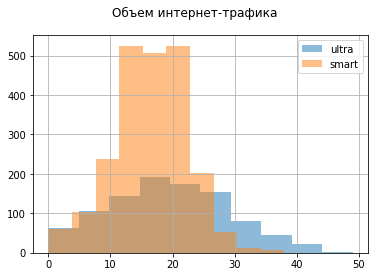

In [23]:
#строю гистограмму распределения объема интернет-трафика в тарифах
df_ultra['gb_used_sum'].hist(alpha = 0.5)
df_smart['gb_used_sum'].hist(alpha = 0.5).legend(['ultra', 'smart'])
plt.suptitle('Объем интернет-трафика')
plt.show()

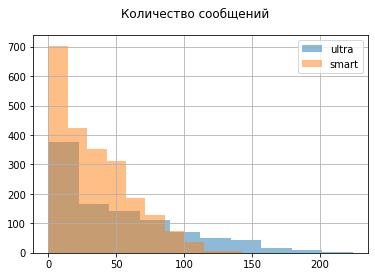

In [24]:
#строю гистограмму распределения количества отправленных сообщений в тарифах
df_ultra['messages_count'].hist(alpha = 0.5)
df_smart['messages_count'].hist(alpha = 0.5).legend(['ultra', 'smart'])
plt.suptitle('Количество сообщений')
plt.show()

<br> В представленной выборке пользователей тарифа Смарт примерно в 2.5 раза больше, чем пользователей тарифа Ультра, это может объясняться их ценой.<br>
У тарифа Ультра средние значения по ключевым показателям: количество минут, сообщений и Гб интернет-трафика больше, это можно объяснить тем, что в пакет услуг входит большее количество этих опций. Вообще получается логичным, что тем, кому нужно больше минут/сообдщений/гигабайт, те должны выбирать тариф, в пакет которого включено больше этих услуг. <br>
Можно сравниить средние показатели пользователей с предоставляемыми пакетами услуг: <br>
Ультра: минуты в среднем 526 (в тарифе - 3000); смс в среднем 49 (в тарифе - 1000); Гб в среднем 20 (в тарифе - 30)<br>
Смарт: минуты в среднем 417 (в тарифе - 500); смс в среднем 33 (в тарифе - 50); Гб в среднем 16 (в тарифе - 15)<br>
На основе этих расчетов можно увидеть, что более разумно используются пакеты услуг в тарифе Смарт, а в тарифе Ультра заложены показатели сверхнормы.<br>
При расчете дисперсии и среднего отклонения видно, что больший разброс этих показателей у пользователей тарифа Ультра. <br>
При построении гистограмм распределения для описанных тарифов выявляется, что длительность звонков до 700 минут характерна для пользователей тарифа Смарт, тогда как большее количество минут уже является отличительной чертой для пользователей тарифа Ультра; по объему интернет-трафика наблюдается схожая картина: все, что свыше 25 Гб характерно для тарифа Ультра; по количеству сообщений можно отметить, что основная масса пользователей обоих тарифов либо не отправляют сообщения вообще, либо очень редко пользуются этой услугой, но на тарифе Ультра тоже отмечается наличие пользователей, которые отправляют много сообщений: больше 100. 

## Проверка гипотез 

In [25]:
#Проверьте гипотезы: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
df_avg_revenue = df_tariffs.pivot_table(index = ['user_id', 'tariff', 'month'], values = 'user_sum', aggfunc = 'first')
df_avg_revenue

user_sum
user_id tariff month          
1000    ultra  5        1950.0
               6        1950.0
               7        1950.0
               8        1950.0
               9        1950.0
...                        ...
1498    smart  10       1750.0
1499    smart  9         550.0
               10       1150.0
               11       1513.0
               12        598.0

[3214 rows x 1 columns]

In [26]:
df_avg_revenue_smart = df_avg_revenue.query('tariff == "smart"')
df_avg_revenue_ultra = df_avg_revenue.query('tariff == "ultra"')
df_avg_revenue_smart
df_avg_revenue_ultra

user_sum
user_id tariff month          
1000    ultra  5        1950.0
               6        1950.0
               7        1950.0
               8        1950.0
               9        1950.0
...                        ...
1495    ultra  8        1950.0
               9        2400.0
               10       1950.0
               11       3300.0
               12       1950.0

[985 rows x 1 columns]

In [27]:
print('Дисперсия Смарт:', df_avg_revenue_smart['user_sum'].var())
print('Дисперсия Ультра:', df_avg_revenue_ultra['user_sum'].var()) 

Дисперсия Смарт: 669785.7080064242
Дисперсия Ультра: 141516.7450786183


Буду использовать Гипотезу о равенстве средних двух генеральных совокупностей, используя метод scipy.stats.ttest_ind (array1, array2, equal_var). Так как выборки не парные, а независимые друг от друга.  

В equal_var передам False, так как нет основания полагать, что выборки взяты из схожих по параметрам совокупностей.  

Гипотезы:  

H0 - средняя выручка выручка пользователей тарифов «Ультра» и «Смарт» равна

H1 - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Критический уровень статистической значимости 0.05, исходя из общепринятых пороговых значений


In [28]:
alpha = 0.05 
results = st.ttest_ind(df_avg_revenue_smart['user_sum'], df_avg_revenue_ultra['user_sum'], equal_var = False)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.2606313931076085e-250
Отвергаем нулевую гипотезу


Нулевая гипотеза о равенстве средней выручки пользователей тарифов «Ультра» и «Смарт» отвергнута стат.тестом 

In [29]:
#Проверьте гипотезы: средняя выручка пользователи из Москвы отличается от выручки пользователей из других регионов.

In [30]:
df_revenue_city = df_tariffs.pivot_table(index = ['user_id', 'city', 'month'], values = 'user_sum', aggfunc = 'first')
df_revenue_city


user_sum
user_id city        month          
1000    Краснодар   5        1950.0
                    6        1950.0
                    7        1950.0
                    8        1950.0
                    9        1950.0
...                             ...
1498    Владикавказ 10       1750.0
1499    Пермь       9         550.0
                    10       1150.0
                    11       1513.0
                    12        598.0

[3214 rows x 1 columns]

In [31]:
df_revenue_moscow = df_revenue_city.query('city == "Москва"')
df_revenue_moscow

user_sum
user_id city   month          
1001    Москва 11       1150.0
               12        550.0
1003    Москва 8        1950.0
               9        1950.0
               10       1950.0
...                        ...
1490    Москва 8         950.0
               9         550.0
               10       1750.0
               11       1350.0
               12        750.0

[611 rows x 1 columns]

In [32]:
df_revenue_region = df_revenue_city.query('city != "Москва"')
df_revenue_region

user_sum
user_id city        month          
1000    Краснодар   5        1950.0
                    6        1950.0
                    7        1950.0
                    8        1950.0
                    9        1950.0
...                             ...
1498    Владикавказ 10       1750.0
1499    Пермь       9         550.0
                    10       1150.0
                    11       1513.0
                    12        598.0

[2603 rows x 1 columns]

Буду использовать Гипотезу о равенстве средних двух генеральных совокупностей, используя метод scipy.stats.ttest_ind (array1, array2, equal_var). 

Так как выборки не парные, а независимые друг от друга. В equal_var передам False, так как нет основания полагать, что выборки взяты из схожих по параметрам совокупностей.


Гипотезы: 


H0 - средняя выручка выручка пользователей из Москвы и регионов равна


H1 - средняя выручка выручка пользователей из Москвы и регионов различается


Критический уровень статистической значимости alpha 0.05, исходя из общепринятых пороговых значений

In [33]:
alpha = 0.05 
results = st.ttest_ind(df_revenue_moscow['user_sum'], df_revenue_region['user_sum'], equal_var = False)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


Нулевую гипотезу о том, что средняя выручка выручка пользователей из Москвы и регионов равна не получилось отвергнуть

In [34]:
print(df_avg_revenue_smart['user_sum'].mean())
print(df_avg_revenue_ultra['user_sum'].mean())

1289.9735307312696
2070.1522842639592


## Общий вывод

<b> Повторяю промежуточный вывод из раздела про описание поведения клиентов оператора, он достаточно многое в себя вместил:</b> <br>
В представленной выборке пользователей тарифа Смарт примерно в 2.5 раза больше, чем пользователей тарифа Ультра, это может объясняться их ценой.<br>
У тарифа Ультра средние значения по ключевым показателям: количество минут, сообщений и Гб интернет-трафика больше, это можно объяснить тем, что в пакет услуг входит большее количество этих опций. Вообще получается логичным, что тем, кому нужно больше минут/сообщений/гигабайт, те должны выбирать тариф, в пакет которого включено больше этих услуг.<br>
Можно сравниить средние показатели пользователей с предоставляемыми пакетами услуг:<br>
Ультра: минуты в среднем 526 (в тарифе - 3000); смс в среднем 49 (в тарифе - 1000); Гб в среднем 20 (в тарифе - 30)<br>
Смарт: минуты в среднем 417 (в тарифе - 500); смс в среднем 33 (в тарифе - 50); Гб в среднем 16 (в тарифе - 15)<br>
На основе этих расчетов можно увидеть, что более разумно используются пакеты услуг в тарифе Смарт, а в тарифе Ультра заложены показатели сверхнормы.<br>
При расчете дисперсии и среднего отклонения видно, что больший разброс этих показателей у пользователей тарифа Ультра.<br>
При построении гистограмм распределения для описанных тарифов выявляется, что длительность звонков до 700 минут характерна для пользователей тарифа Смарт, тогда как большее количество минут уже является отличительной чертой для пользователей тарифа Ультра; по объему интернет-трафика наблюдается схожая картина: все, что свыше 25 Гб характерно для тарифа Ультра; по количеству сообщений можно отметить, что основная масса пользователей обоих тарифов либо не отправляют сообщения вообще, либо очень редко пользуются этой услугой, но на тарифе Ультра тоже отмечается наличие пользователей, которые отправляют много сообщений: больше 100.<br>
<b> Дополнение:</b> <br>
Гипотеза о равенстве средней выручки пользователей тарифов «Ультра» и «Смарт» отвергнута стат.тестом, а гипотезу о равенстве средней выручки пользователей из Москвы и регионов отвергнуть не получилось. <br>
Если гипотезу отвергнуть не получилось, это не значит, что мы ее будем принимать.
Но я думаю, что исходя из предоставленных данных, можно сделать выводы о тарифах, поэтому я расчитала среднее для выручки оператора по тарифам, больше тратят пользователи тарифа Ультра: 2070 руб, помня, что абонентская плата по тарифу составляет 1950руб, получается, что некоторые пользователи не вписываются в лимиты и в среднем доплачивают около 120 рублей<br>
В тарифе Смарт средняя выручка - 1290руб, на этом тарифе абонентская плата составляет 550 руб, а доплачивают пользователи гораздо больше - в среднем 740 руб.<br>
Трудно сказать однозначно, но я бы приняла решение продвигать именно тариф Смарт: его и так предпочитают больше пользователей, в нем соблюден баланс лимитов по минутам/смс/Гб, а пользователи охотно доплачивают за использование дополнительных мощностей. Если провести рекламную кампанию, можно привлечь еще больше пользователей. Они охотней принимают тариф с относительно небольшой абонентской платой, активно докупают дополнительные минуты/смс/Гб, в среднем стоимость этих допов достигает 1.4 стоимости тарифа. <br>
Также, если исследовать нашу выборку и умножить количество пользователей на среднюю выручку, выходит что тариф Смарт приносит больше денег.<br>
по выборке:<br>
(Количество пользователей Смарт - 350, средняя выручка 1290. сумма 451тыс<br>
Количество пользователей Ультра - 148, средняя выручка 2070. сумма 306тыс)

# Чек-лист готовности проекта
- [x]  Откройте файл с данными 
- [x]  изучите общую информацию
- [x]  Приведите данные к нужным типам;
- [x]  Найдите и исправьте ошибки в данных, если они есть.
- [x]  Поясните, какие ошибки вы нашли и как их исправили. В данных вы найдёте звонки с нулевой продолжительностью. Это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять.
- [x]  Посчитайте для каждого пользователя: количество сделанных звонков и израсходованных минут разговора по месяцам;
- [x]  Посчитайте для каждого пользователя: количество отправленных сообщений по месяцам;
- [x]  Посчитайте для каждого пользователя: объем израсходованного интернет-трафика по месяцам;
- [x]  Посчитайте для каждого пользователя: помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).
- [x]  Проанализируйте данные: Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.
- [x]  Проверьте гипотезы: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- [x]  Проверьте гипотезы: средняя выручка пользователи из Москвы отличается от выручки пользователей из других регионов.
- [x]  Поясните:как вы формулировали нулевую и альтернативную гипотезы; какой критерий использовали для проверки гипотез и почему.
- [x]  сделайте общий вывод
- [x]  в каждом этапе есть выводы
